# Get Data

In [1]:
!wget https://files.rcsb.org/download/2jyh.pdb
!wget https://files.rcsb.org/download/1AJF.pdb

--2024-02-09 09:10:49--  https://files.rcsb.org/download/2jyh.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.100
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2jyh.pdb’

2jyh.pdb                [ <=>                ]   1.08M  --.-KB/s    in 0.1s    

2024-02-09 09:10:49 (9.66 MB/s) - ‘2jyh.pdb’ saved [1131084]

--2024-02-09 09:10:49--  https://files.rcsb.org/download/1AJF.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.100
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1AJF.pdb’

1AJF.pdb                [ <=>                ]  62.02K  --.-KB/s    in 0.04s   

2024-02-09 09:10:49 (1.50 MB/s) - ‘1AJF.pdb’ saved [63504]



In [2]:
!wget https://github.com/RNA-Puzzles/raw_dataset_and_for_assessment/tree/master/raw

--2024-02-09 09:10:49--  https://github.com/RNA-Puzzles/raw_dataset_and_for_assessment/tree/master/raw
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3893 (3.8K) [text/plain]
Saving to: ‘raw’

raw                 100%[===================>]   3.80K  --.-KB/s    in 0s      

2024-02-09 09:10:49 (48.7 MB/s) - ‘raw’ saved [3893/3893]



In [3]:
import gdown

In [4]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [5]:
!ls -lh

total 1.2M
-rw-r--r-- 1 root root  63K Feb  9 09:10 1AJF.pdb
-rw-r--r-- 1 root root 1.1M Feb  9 09:10 2jyh.pdb
-rw-r--r-- 1 root root 3.9K Feb  9 09:10 raw
drwxr-xr-x 1 root root 4.0K Feb  7 14:24 sample_data


In [6]:
!mkdir pdbs
!mv *.pdb* pdbs

# Part I: Compute interatomic distances from PDB files

In [7]:
!grep "^ATOM" pdbs/2jyh.pdb > prot.atoms

In [8]:
!head prot.atoms -n 10

ATOM      1  O5'   G A   1      29.747 -31.359  16.520  1.00  1.00           O  
ATOM      2  C5'   G A   1      30.663 -32.049  15.666  1.00  1.00           C  
ATOM      3  C4'   G A   1      29.958 -32.614  14.432  1.00  1.00           C  
ATOM      4  O4'   G A   1      29.070 -33.668  14.819  1.00  1.00           O  
ATOM      5  C3'   G A   1      29.131 -31.585  13.664  1.00  1.00           C  
ATOM      6  O3'   G A   1      29.877 -31.098  12.544  1.00  1.00           O  
ATOM      7  C2'   G A   1      27.932 -32.378  13.179  1.00  1.00           C  
ATOM      8  O2'   G A   1      28.176 -32.975  11.897  1.00  1.00           O  
ATOM      9  C1'   G A   1      27.774 -33.433  14.256  1.00  1.00           C  
ATOM     10  N9    G A   1      26.885 -33.026  15.352  1.00  1.00           N  


## Script to parse pdbs into distance distributions

In [9]:
import os
import itertools
import numpy as np

def parse_pdb(file_path):
    c3_atoms = []

    with open(file_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith("ATOM") and line[12:16].strip() == "C3'":
                atom_info = {
                    'residue_name': line[17:20].strip(),
                    'chain_id': line[21],
                    'residue_seq': int(line[22:26].strip()),
                    'x_coord': float(line[30:38].strip()),
                    'y_coord': float(line[38:46].strip()),
                    'z_coord': float(line[46:54].strip()),
                }
                c3_atoms.append(atom_info)

    return c3_atoms

def compute_intra_chain_distances(c3_atoms):
    distances = []

    for atom1, atom2 in itertools.combinations(c3_atoms, 2):
        if atom1['chain_id'] == atom2['chain_id'] and abs(atom1['residue_seq'] - atom2['residue_seq']) >= 3:
            distance = np.linalg.norm(np.array([atom1['x_coord'], atom1['y_coord'], atom1['z_coord']]) -
                                      np.array([atom2['x_coord'], atom2['y_coord'], atom2['z_coord']]))
            distances.append(distance)

    return distances

def main():
    pdb_dir = "pdbs"  # Replace with the directory with your PDB files

    base_pairs = ['AA', 'AU', 'AC', 'AG', 'UU', 'UC', 'UG', 'CC', 'CG', 'GG']
    distances_for_base_pair = {}

    for base_pair in base_pairs:
        for pdb_file in os.listdir(pdb_dir):
            if pdb_file.endswith(".pdb"):
                pdb_file_path = os.path.join(pdb_dir, pdb_file)
                c3_atoms = parse_pdb(pdb_file_path)

                chain1_atoms = [atom for atom in c3_atoms if atom['residue_name'] == base_pair[0]] # It's not actually chains - confusing naming
                chain2_atoms = [atom for atom in c3_atoms if atom['residue_name'] == base_pair[1]] # It's also ineffective part of the scrip since it does not filter
                # for chains here deligating it to the downstream function?

                distances = compute_intra_chain_distances(chain1_atoms + chain2_atoms)
                distances_for_base_pair[base_pair] = distances

        mean_distance = np.mean(distances_for_base_pair[base_pair])
        std_dev = np.std(distances_for_base_pair[base_pair])

        print(f'{base_pair} - Mean distance: {mean_distance:.2f}, Standard Deviation: {std_dev:.2f}')

    return distances_for_base_pair

if __name__ == "__main__":
    distances_for_base_pair = main()

AA - Mean distance: 30.89, Standard Deviation: 11.47
AU - Mean distance: 27.54, Standard Deviation: 12.02
AC - Mean distance: 30.19, Standard Deviation: 12.43
AG - Mean distance: 30.55, Standard Deviation: 13.67
UU - Mean distance: 24.76, Standard Deviation: 9.30
UC - Mean distance: 27.88, Standard Deviation: 10.49
UG - Mean distance: 28.15, Standard Deviation: 12.50
CC - Mean distance: 32.58, Standard Deviation: 10.71
CG - Mean distance: 30.52, Standard Deviation: 13.55
GG - Mean distance: 31.39, Standard Deviation: 14.71


## Script Testing

In [10]:
c3_atoms = parse_pdb('/content/pdbs/2jyh.pdb')
c3_atoms[:3]

[{'residue_name': 'G',
  'chain_id': 'A',
  'residue_seq': 1,
  'x_coord': 29.131,
  'y_coord': -31.585,
  'z_coord': 13.664},
 {'residue_name': 'G',
  'chain_id': 'A',
  'residue_seq': 2,
  'x_coord': 25.443,
  'y_coord': -29.12,
  'z_coord': 10.169},
 {'residue_name': 'G',
  'chain_id': 'A',
  'residue_seq': 3,
  'x_coord': 21.534,
  'y_coord': -25.134,
  'z_coord': 8.001}]

In [11]:
len(c3_atoms)

430

In [12]:
np.mean(compute_intra_chain_distances(c3_atoms))

28.891339551090855

In [13]:
compute_intra_chain_distances(c3_atoms)[:10]

[17.136120068440228,
 21.514609617652837,
 26.941537558201833,
 30.571748412545855,
 31.7308096020256,
 36.75841053418931,
 41.27567014598309,
 45.49222742403366,
 50.054202920434165,
 53.27828481661173]

In [14]:
combos = itertools.combinations(c3_atoms[:5], 2)
for combo in combos:
  print(combo)

({'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 1, 'x_coord': 29.131, 'y_coord': -31.585, 'z_coord': 13.664}, {'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 2, 'x_coord': 25.443, 'y_coord': -29.12, 'z_coord': 10.169})
({'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 1, 'x_coord': 29.131, 'y_coord': -31.585, 'z_coord': 13.664}, {'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 3, 'x_coord': 21.534, 'y_coord': -25.134, 'z_coord': 8.001})
({'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 1, 'x_coord': 29.131, 'y_coord': -31.585, 'z_coord': 13.664}, {'residue_name': 'A', 'chain_id': 'A', 'residue_seq': 4, 'x_coord': 17.37, 'y_coord': -20.824, 'z_coord': 7.377})
({'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 1, 'x_coord': 29.131, 'y_coord': -31.585, 'z_coord': 13.664}, {'residue_name': 'U', 'chain_id': 'A', 'residue_seq': 5, 'x_coord': 15.512, 'y_coord': -15.656, 'z_coord': 8.799})
({'residue_name': 'G', 'chain_id': 'A', 'residue_seq': 2, 'x_coord': 25.4

In [15]:
{'x_coord': 29.131, 'y_coord': -31.585, 'z_coord': 13.664}.values()

dict_values([29.131, -31.585, 13.664])

In [16]:
{'x_coord': 25.443, 'y_coord': -29.12, 'z_coord': 10.169}.values()

dict_values([25.443, -29.12, 10.169])

In [17]:
np.linalg.norm(np.array([29.131, -31.585, 13.664]) - np.array([25.443, -29.12, 10.169]))

5.647352831194452

In [18]:
((29.131 - 25.443)**2 + (-31.585 - -29.12)**2 + (13.664 - 10.169)**2)**(1/2)

5.647352831194452

In [19]:
distances_for_base_pair['AA'][:5]

[28.645427575792965,
 31.678561504588558,
 37.80928433599346,
 40.70041650892531,
 55.98642550654578]

In [20]:
distances_for_base_pair['UC'][:5]

[34.74603564437244,
 29.823080826769054,
 23.95199023045893,
 22.27661513785252,
 19.853324482312782]

## Plot Distances Distributions

In [21]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

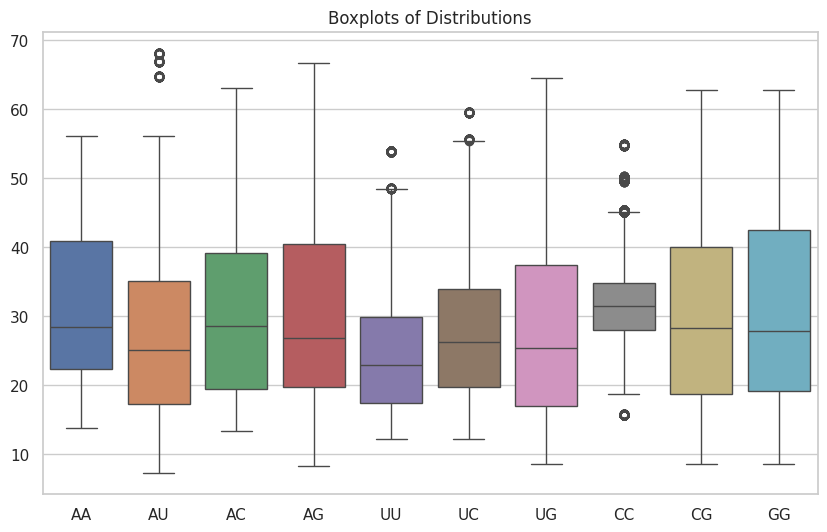

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(distances_for_base_pair, orient='index').transpose()

# Plot boxplots using Seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(data=df)
plt.title('Boxplots of Distributions')
plt.savefig('boxplot.png')
plt.show()


<Axes: ylabel='Count'>

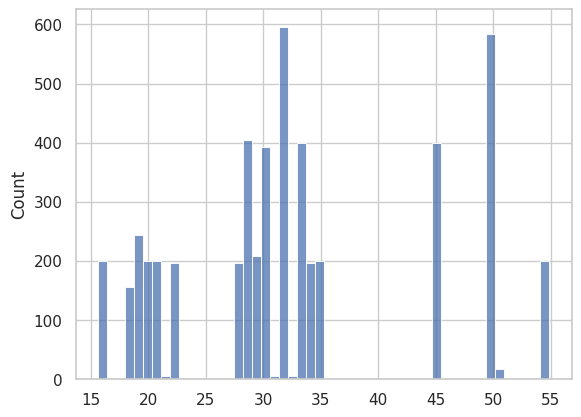

In [23]:
sns.histplot(distances_for_base_pair['CC'])

<Axes: ylabel='Count'>

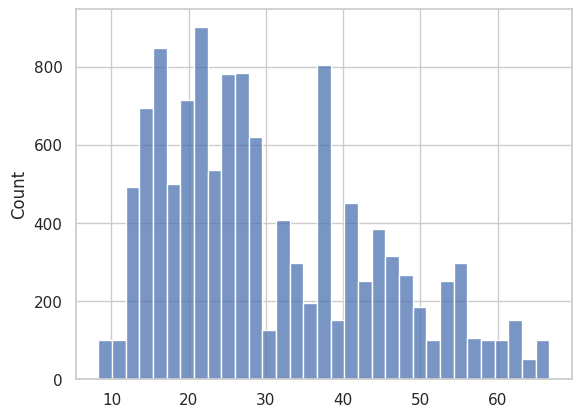

In [24]:
sns.histplot(distances_for_base_pair['AG'])

<Axes: ylabel='Count'>

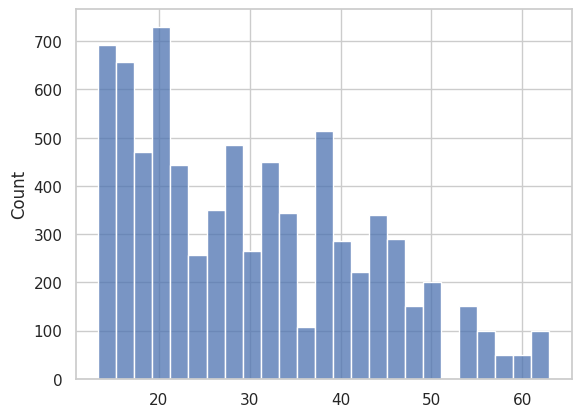

In [25]:
sns.histplot(distances_for_base_pair['AC'])

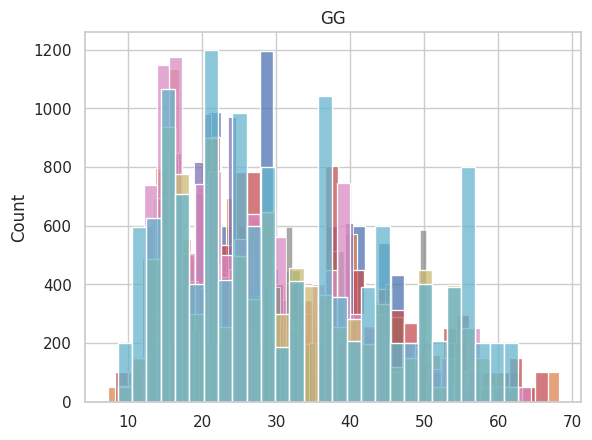

In [26]:
for key, value in distances_for_base_pair.items():
  ax = sns.histplot(value)
  plt.title(key)

# Part II

In [27]:
distances_for_base_pair['AA'][:10]

[28.645427575792965,
 31.678561504588558,
 37.80928433599346,
 40.70041650892531,
 55.98642550654578,
 53.78739327202984,
 50.68953328844132,
 13.856128211011907,
 15.76119668680015,
 28.60676830751772]

In [28]:
#far from all distances are in the range [1;20]. But here we assume they are by dividing by len(dists)

In [29]:
def compute_frequencies(distances):
    bins = np.linspace(0, 20, 21)  # 20 intervals from 0 to 20 Å
    counts, _ = np.histogram(distances, bins=bins)
    frequencies = counts / len(distances)
    return frequencies

def compute_log_ratios(observed_frequencies, reference_frequencies):
    # Avoid zero division, set NaN to 0
    log_ratios = -np.log(np.divide(observed_frequencies, reference_frequencies, out=np.zeros_like(observed_frequencies), where=reference_frequencies!=0))
    return log_ratios

In [30]:
def calculate_pseudo_energy(distances_dict: dict, output_dir='pseudo_energies'):
  reference_frequencies = compute_frequencies([value for values in distances_dict.values() for value in values])
  energy_dict = {}

  for key, value in distances_dict.items():
    observed_frequencies = compute_frequencies(value)
    log_ratios = compute_log_ratios(observed_frequencies, reference_frequencies)
    energy_dict[key] = log_ratios

  return energy_dict

In [31]:
def write_energy_dict(energy_dict: dict, file_type = 'txt', output_dir = 'pseudo_energies'):
  if not os.path.exists(output_dir):
        os.makedirs(output_dir)

  if file_type == 'txt':
    for key, value in energy_dict.items():
      output_path = os.path.join(output_dir, f'{key}_scores.txt')
      np.savetxt(output_path, value, delimiter='\n', fmt='%s')

  elif file_type == 'csv':
    energy_df = pd.DataFrame.from_dict(energy_dict)
    energy_df.to_csv(f'{output_dir}/pseudo_energies.csv')

  else:
    print(f'File type {file_type} is not supported')

In [32]:
#!rm -r pseudo_energies

In [33]:
#!rm *.txt*

In [34]:
energy_dict = calculate_pseudo_energy(distances_for_base_pair)
energy_dict['AA']

<ipython-input-29-d6e6b6078bcb>:9: RuntimeWarning: divide by zero encountered in log
  log_ratios = -np.log(np.divide(observed_frequencies, reference_frequencies, out=np.zeros_like(observed_frequencies), where=reference_frequencies!=0))


array([        inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf, -0.04331879,  1.28727941,
       -0.44575685,  4.54533352,         inf,  0.26617958,  0.32227573])

In [35]:
write_energy_dict(energy_dict)

In [36]:
write_energy_dict(energy_dict, 'csv')

In [37]:
write_energy_dict(energy_dict, 'mp4')

File type mp4 is not supported


In [38]:
pd.DataFrame.from_dict(energy_dict)

,AA,AU,AC,AG,UU,UC,UG,CC,CG,GG
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,-2.228842,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,-0.701344,inf,inf,0.024195,inf,-0.238568,-1.281751
9,inf,-2.228842,inf,inf,inf,inf,inf,inf,inf,inf


In [39]:
bins = np.linspace(0, 20, 21)
bins

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [40]:
compute_frequencies(distances_for_base_pair['AA'])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03234043, 0.01021277,
       0.08468085, 0.00042553, 0.        , 0.0212766 , 0.0212766 ])

In [41]:
ref_freqs = compute_frequencies([value for values in distances_for_base_pair.values() for value in values])
ref_freqs

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0005102 , 0.00408163, 0.0005102 ,
       0.0005102 , 0.00588776, 0.01682653, 0.03096939, 0.037     ,
       0.05422449, 0.04008163, 0.02441837, 0.02776531, 0.02936735])

In [42]:
'''    print(f'Log ratios for {key}')
    print(log_ratios)'''

"    print(f'Log ratios for {key}')\n    print(log_ratios)"

In [43]:
calculate_pseudo_energy(distances_for_base_pair)

<ipython-input-29-d6e6b6078bcb>:9: RuntimeWarning: divide by zero encountered in log
  log_ratios = -np.log(np.divide(observed_frequencies, reference_frequencies, out=np.zeros_like(observed_frequencies), where=reference_frequencies!=0))


{'AA': array([        inf,         inf,         inf,         inf,         inf,
                inf,         inf,         inf,         inf,         inf,
                inf,         inf,         inf, -0.04331879,  1.28727941,
        -0.44575685,  4.54533352,         inf,  0.26617958,  0.32227573]),
 'AU': array([        inf,         inf,         inf,         inf,         inf,
                inf,         inf, -2.22884162,         inf, -2.22884162,
                inf, -0.47616954, -0.11923466,  0.16872422, -0.33374202,
        -0.27347782, -0.22959944, -0.60763392,  0.10775909,  0.1156084 ]),
 'AC': array([        inf,         inf,         inf,         inf,         inf,
                inf,         inf,         inf,         inf,         inf,
                inf,         inf,         inf,  0.28683375, -0.38334319,
        -0.18424714,  0.26830671,  1.9784594 , -0.44012738, -0.45663204]),
 'AG': array([        inf,         inf,         inf,         inf,         inf,
                inf, 

# Part 3

In [44]:
#!mkdir 7fhi
#!cp data/*7FHI* 7fhi/

In [45]:
energies = pd.read_csv('/content/pseudo_energies/pseudo_energies.csv', index_col=0)
energies.index = [i for i in range(1,21)]
energies = energies.T
energies

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AA,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,-0.043319,1.287279,-0.445757,4.545334,inf,0.266180,0.322276
AU,inf,inf,inf,inf,inf,inf,inf,-2.228842,inf,-2.228842,inf,-0.476170,-0.119235,0.168724,-0.333742,-0.273478,-0.229599,-0.607634,0.107759,0.115608
AC,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.286834,-0.383343,-0.184247,0.268307,1.978459,-0.440127,-0.456632
AG,inf,inf,inf,inf,inf,inf,inf,inf,-0.701344,inf,inf,-0.439326,-0.104664,0.104328,0.321350,0.254092,-0.105172,-0.121466,0.104089,0.324253
UU,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,-0.865923,-0.255880,1.269112,-0.484204,-0.037182,-0.493544,0.526506,-0.874310
UC,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.219267,0.829309,0.284522,-0.087606,-0.034450,-0.320637,-0.291504,-0.107574
UG,inf,inf,inf,inf,inf,inf,inf,inf,0.024195,inf,-2.055247,0.191722,-0.123786,-0.379402,-0.522494,0.067655,-0.394087,-0.149874,0.344120,-0.266263
CC,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.304253,inf,inf,-0.985669,1.657117
CG,inf,inf,inf,inf,inf,inf,inf,inf,-0.238568,inf,inf,-0.071041,0.245728,0.105246,-0.492025,0.365688,-0.344743,-0.372517,0.312631,0.928342
GG,inf,inf,inf,inf,inf,inf,inf,inf,-1.281751,inf,inf,-1.114224,-0.441904,-0.353861,-0.114067,1.139371,-0.095942,0.448819,0.025774,0.596326


In [46]:
energies.replace([np.inf, -np.inf], 0, inplace=True)
energies

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.043319,1.287279,-0.445757,4.545334,0.000000,0.266180,0.322276
AU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.228842,0.000000,-2.228842,0.000000,-0.476170,-0.119235,0.168724,-0.333742,-0.273478,-0.229599,-0.607634,0.107759,0.115608
AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.286834,-0.383343,-0.184247,0.268307,1.978459,-0.440127,-0.456632
AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.701344,0.000000,0.000000,-0.439326,-0.104664,0.104328,0.321350,0.254092,-0.105172,-0.121466,0.104089,0.324253
UU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.865923,-0.255880,1.269112,-0.484204,-0.037182,-0.493544,0.526506,-0.874310
UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.219267,0.829309,0.284522,-0.087606,-0.034450,-0.320637,-0.291504,-0.107574
UG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.024195,0.000000,-2.055247,0.191722,-0.123786,-0.379402,-0.522494,0.067655,-0.394087,-0.149874,0.344120,-0.266263
CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304253,0.000000,0.000000,-0.985669,1.657117
CG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.238568,0.000000,0.000000,-0.071041,0.245728,0.105246,-0.492025,0.365688,-0.344743,-0.372517,0.312631,0.928342
GG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.281751,0.000000,0.000000,-1.114224,-0.441904,-0.353861,-0.114067,1.139371,-0.095942,0.448819,0.025774,0.596326


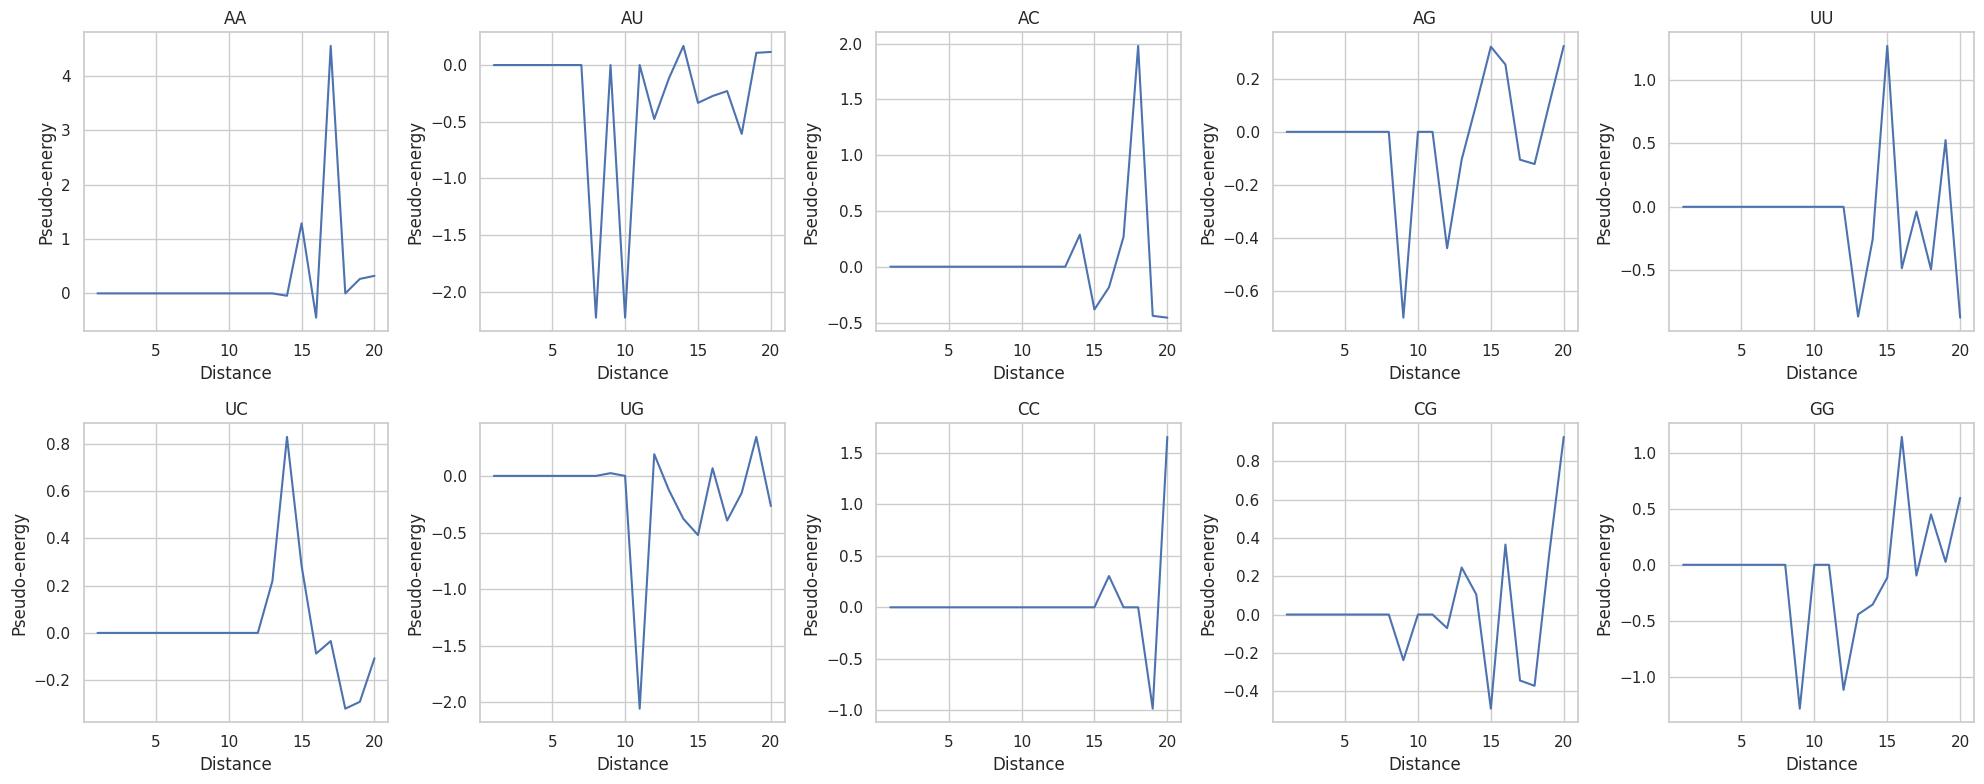

In [53]:
import matplotlib.pyplot as plt

# Get the indexes and values from the DataFrame
indexes = energies.index.tolist()
values = energies.values

# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 5

# Create a new figure
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 8))

# Flatten the axes to iterate over them
ax = ax.flatten()

# Iterate over each subplot
for i, ax_i in enumerate(ax):
    # Plot the line for the corresponding pair of residues
    ax_i.plot(range(1, 21), values[i])

    # Set labels and title
    ax_i.set_ylabel("Pseudo-energy")
    ax_i.set_xlabel("Distance")
    ax_i.set_title(indexes[i])

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('pseudo-energies.png')

# Show the plot
plt.show()


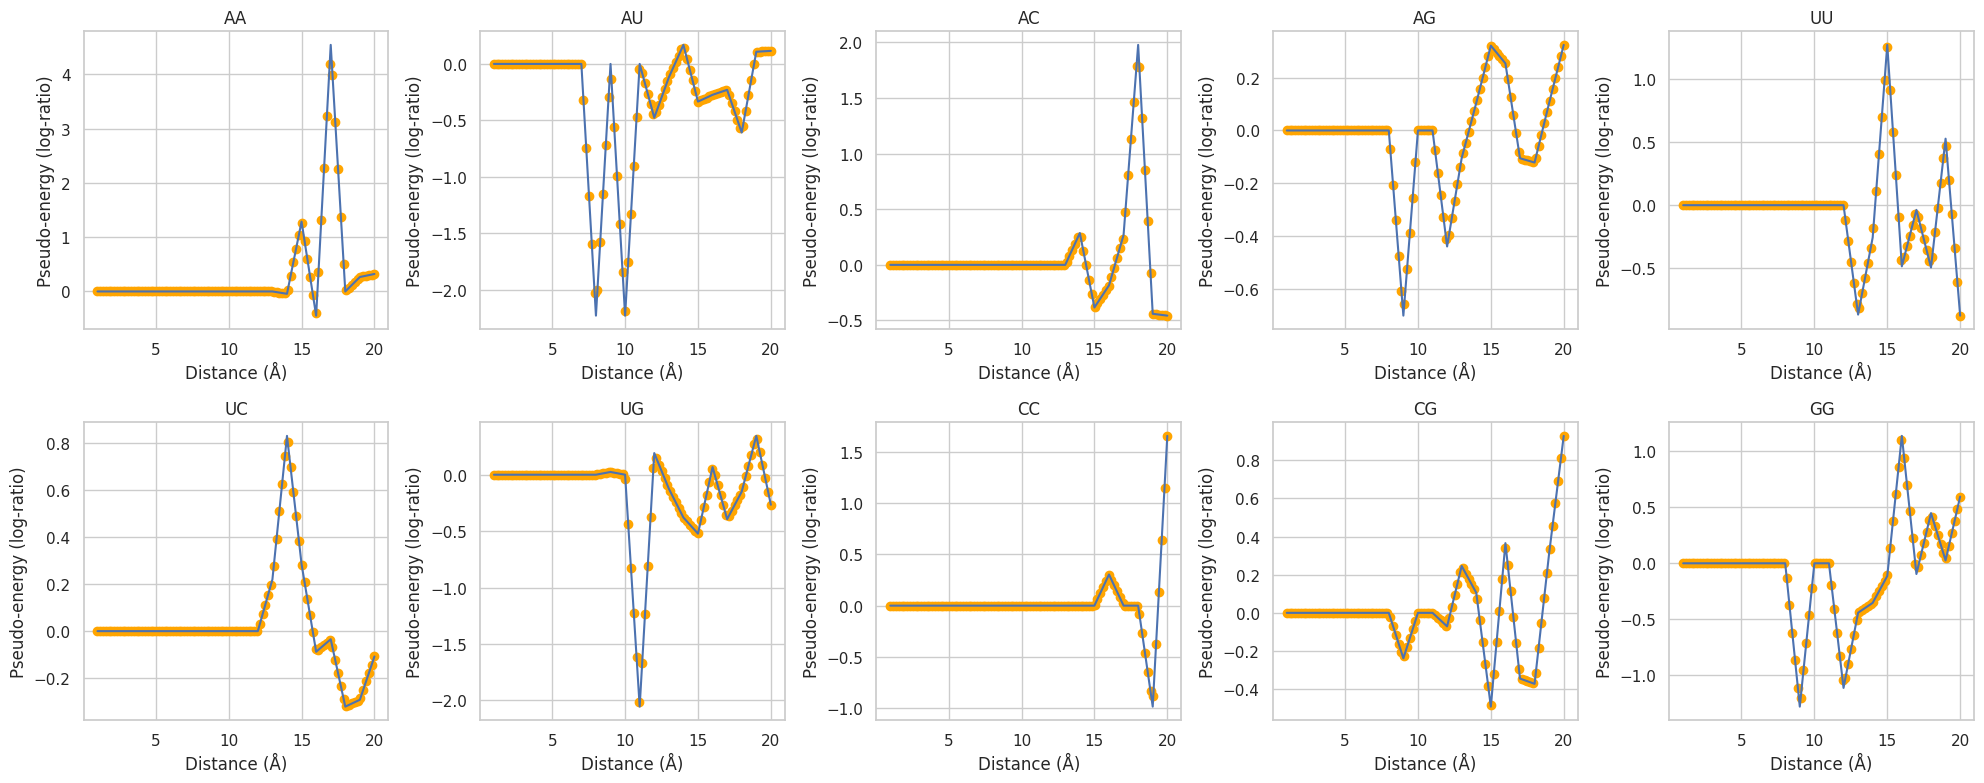

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def linear_interpolation(x_values, y_values):
    """
    Performs linear interpolation for a set of points.

    Parameters:
    - x_values: List or numpy array of x values
    - y_values: List or numpy array of corresponding y values

    Returns:
    - Function that takes an x value or array and outputs the interpolated y value or array
    """
    x_values, y_values = np.asarray(x_values), np.asarray(y_values)

    def interpolate(x):
        indices = np.searchsorted(x_values, x, side='right')
        indices = np.clip(indices, 1, len(x_values) - 1)
        x0, x1 = x_values[indices - 1], x_values[indices]
        y0, y1 = y_values[indices - 1], y_values[indices]
        return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

    return np.vectorize(interpolate)

# Create subplots
fig, ax = plt.subplots(2, 5, figsize=(20, 8), squeeze=False)

# Flatten axes
ax = ax.flatten()

# Iterate over each subplot
for q, ax_i in enumerate(ax):
    # Plot the original line
    ax_i.plot(np.arange(1, 21), energies.iloc[q, :])

    # Perform linear interpolation
    interpol = linear_interpolation(x_values=energies.iloc[q].index.astype('float').values, y_values=energies.iloc[q].values)
    interpols = interpol(np.linspace(1, 20, 100))

    # Scatter plot the interpolated points
    ax_i.scatter(x=np.linspace(1, 20, 100), y=interpols, color='orange')

    # Set labels and title
    ax_i.set_ylabel("Pseudo-energy (log-ratio)")
    ax_i.set_xlabel("Distance (Å)")
    ax_i.set_title(indexes[q])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Rework